# Trabajo Computacional TC_01

##### Heli Magali García Álvarez
##### Santiago Scheiner
##### Juan Ignacio Gossn

### Bloque de inicialización

Importamos todos los modulos que necesitaremos para el trabajo:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from matplotlib import pylab
from sklearn.linear_model import LinearRegression
import random
import matplotlib.patches as mpatches
from statsmodels.stats.proportion import proportions_ztest
import collections
import jgraph
import itertools
from matplotlib_venn import venn3, venn3_circles

### Selección de path según la máquina de trabajo:

In [2]:
pathHeli = '/home/heli/Documents/Redes/Practicas/TC_01/'
pathJuancho = '/home/gossn/Dropbox/Documents/Materias_doctorado/RedesComplejas/tc01_data/'
pathSanti = '/home/santiago/Documentos/RC/tc01_data/'
pathDocente = '?'

path = pathHeli

Configuraciones para los gráficos:

In [3]:
plt.close('all')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

TitleSize=20
AxisLabelSize=20
LegendSize=11
NumberSize=12
LabelSize=8 # etiquetas de los nodos
NodeSize=50 # tamaño de los nodos

Definición de función de lectura de las tablas:

In [4]:
def ldata(archivo):

    f=open(archivo)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

### Ej. 1: Considere las tres redes de interacción de proteínas relevadas para levadura disponibles en la página de la materia. Se trata de: una red de interacciones binarias (yeast_Y2H.txt), de copertenencia a complejos proteicos (yeast_AP-MS.txt) y obtenida de literatura (yeast_LIT.txt) obtenidas del Yeast Interactome Database.

Se cargan los datos:

In [5]:
redesStr = ['Y2H','AP-MS','LIT']
redes = {}

for s in redesStr:
    redes[s] = nx.Graph(ldata(path + 'yeast_' + s + '.txt'))

### Ej. 1(a): Presente una comparación gráfica de las 3 redes.

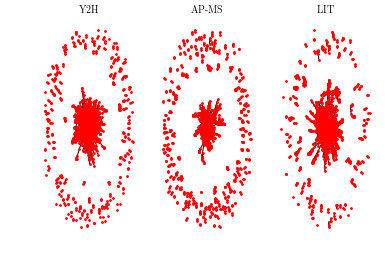

In [6]:
%matplotlib inline
fig, axs = plt.subplots(1,len(redesStr))
axs = axs.ravel()
sp = -1
for s in redesStr:
    sp += 1

    plt.sca(axs[sp])
    # draw all nodes homogeneously, and edge weights as filtered
    nx.draw(redes[s], with_labels=False, node_size=3, axs=axs[sp])

    axs[sp].set_title(s, fontsize=10)
    axs[sp].set_axis_off()

### Ej. 1(b) Resuma en una tabla las siguientes características de dichas redes:

#### i. El número total de nodos, N
#### ii. El número total de enlaces L, de la red
#### iii. Si se trata de una red dirigida o no-dirigida
#### iv. El grado medio/máximo/mínimo de la red
#### v. La densidad de la red
#### vi. Los coeficientes de clustering <Ci> y C_delta de la red.
#### vii. Diámetro de la red.

Armamos un dataframe, correspondiente al modulo "pandas":

In [21]:
df1b = pd.DataFrame()

for s in redesStr:
	# i
	df1b.loc[s,'Nodes'] = redes[s].number_of_nodes()
	# ii
	df1b.loc[s,'Edges'] = redes[s].number_of_edges()
	# iii
	if len(redes[s]) == len(np.unique(redes[s],axis=0)):
		df1b.loc[s,'Directionality'] = 'Prob-Undir'
	else:
		df1b.loc[s,'Directionality'] = 'Dir'
	# iv
	netDeg = np.array(list(redes[s].degree()))
	netDeg = netDeg[:,1]
	netDeg = netDeg.astype(int)
	df1b.loc[s,'DegMean'] = np.mean(netDeg)
	df1b.loc[s,'DegMin'] = np.min(netDeg)
	df1b.loc[s,'DegMax'] = np.max(netDeg)
	# v
	df1b.loc[s,'DegDensity'] = nx.density(redes[s])
	# vi
	df1b.loc[s,'C_tri'] = nx.transitivity(redes[s])
	df1b.loc[s,'C_avg'] = nx.average_clustering(redes[s])
	# vii Dado que las redes son disconexas, estimamos el diametro de la componente gigante
	giant = max(nx.connected_component_subgraphs(redes[s]), key=len)
	df1b.loc[s,'Diameter (Giant Subgraph)'] = nx.diameter(giant)

print(df1b)



        Nodes   Edges Directionality    DegMean  DegMin  DegMax  DegDensity  \
Y2H    2018.0  2930.0     Prob-Undir   2.903865     1.0    91.0    0.001440   
AP-MS  1622.0  9070.0     Prob-Undir  11.183724     1.0   127.0    0.006899   
LIT    1536.0  2925.0     Prob-Undir   3.808594     1.0    40.0    0.002481   

          C_tri     C_avg  Diameter (Giant Subgraph)  
Y2H    0.023614  0.046194                       14.0  
AP-MS  0.618590  0.554636                       15.0  
LIT    0.346193  0.292492                       19.0  


### 1(b)* Analizar cómo calcular las características de la red a partir de la matriz de adyacencia.

##### Cantidad de nodos ($N$):
Cantidad de filas (o columnas) de la matriz.

##### Número total de enlaces ($L$):
Cantidad de coeficientes no nulos tiene en la matriz (en total, i.e. en todas sus filas y columnas), dividido por dos, de modo de no contar el mismo enlace en ambos sentidos.

##### Red dirigida o no dirigida:
Si es simétrica, la red es no dirigida. Si es asimétrica, la red es dirigida. Esto significa que la interacción del nodo $i$ con el $j$ es distinta que la del $j$ con el $i$, por lo que el coeficiente $a_{ij}$ es diferente del $a_{ji}$.

#####  Grado medio ($\langle k \rangle$):
La media de la cantidad de elementos no nulos de cada fila (o columna).

##### Grado máximo ($k_{max}$):
Máximo de las cantidades de elementos no nulos de las filas (o columnas).

##### Grado mínimo ($k_{min}$):
Mínimo de las cantidades de elementos no nulos de las filas (o columnas).

##### Densidad: (cantidad de enlaces / cantidad de enlaces posibles)
Cantidad de elementos no nulos en la matriz, dividido por la cantidad total de elementos de la matriz ($N^2$).

##### Diámetro:
Una posibilidad es utilizar el algoritmo de Dijkstra para hallar el mínimo camino entre dos nodos e implementarlo para todos los pares posibles de nodos. El máximo camino hallado para algún par es el diámetro del grafo.

### Conclusión:

Algunas de los procedimientos detallados arriba pueden resultar costosos computacionalmente. El ejemplo más claro es quizás el cálculo del diámetro, que en el peor de los escenarios puede tener un orden de complejidad $O(N^2)$ para el algoritmo de Dijkstra, y $O(N^2)$ para hacerlo para todos los pares de nodos posibles en la red, lo que significa que el algoritmo tiene un orden de complejidad de $O(N^4)$. Para redes muy grandes, estos algoritmos se vuelven inviables.
La conclusión que puede sacarse entonces es que las librerías utilizadas muy probablemente implementen algoritmos muchos más eficientes que estos procedimientos elementales.

### Ej. 1(c): Teniendo en cuenta la naturaleza de las interacciones reportadas, diga si es razonable lo que encuentra para ciertos observables calculados.

Las tres redes estudiadas corresponden a un mismo sistema biológico, pero cuyas interacciones son medidas mediante diferentes técnicas experimentales.

Y2H (Yeast two Hybrid) es una técnica de biología molecular (bastante "artesanal" en comparación con las restantes) para obtener interacciones entre proteínas, que arrojará pares interactuantes (X con Y, X con Z, siendo la proteína X anzuelo o bait en el experimento e Y, Z los proteínas pescadas o presas). En el grafo se observan muchas de estas "X", es decir que se repitió este experimento para distintas proteínas anzuelo. Dado que este método releva interacciones binarias, es de esperar un clustering bajo en comparación con los métodos restantes, que relevan complejos de más proteínas.
 
Por otro lado, AP-MS (Affinity Purification followed by Mass Spectroscopy) es una técnica de alto rendimiento, con lo cual esperamos tener información de muchas más interacciones en comparación con Y2H, pero a su vez información más inespecífica ya que este experimento releva complejos de proteínas interactuantes relacionados a una POI (proteína de interés). Esto se traduce a coeficientes de clustering más elevados que en Y2H.

Por último, LIT (Linear Ion Trap) es una forma más sofisticada de AP-MS en que se dismuye el número de interacciones espurias (dentro de los complejos de proteínas interactuantes) obtenidas por AP-MS, por lo cual otorga un coeficiente de clustering intermedio entre Y2H y AP-MS.

### Ej. 1(d): Construya un diagrama de Venn que permita reconocer la cobertura, especificidad y coherencia de las interacciones reportadas por los tres datasets

En primer lugar, para las 3 redes, generamos subgrafos que tengan los mismos nodos, es decir eliminamos los nodos que no aparecen en los 3 grafos a analizar.

In [6]:
commonNodes = []

for nodoi in list(redes['Y2H']):
    if nodoi not in redes['LIT']:
        redes['Y2H'].remove_node(nodoi)
    elif nodoi not in redes['AP-MS']:
        redes['Y2H'].remove_node(nodoi)
    else:
        commonNodes.append(nodoi)

for nodoi in list(redes['AP-MS']):
    if nodoi not in commonNodes:
        redes['AP-MS'].remove_node(nodoi)

for nodoi in list(redes['LIT']):
    if nodoi not in commonNodes:
        redes['LIT'].remove_node(nodoi)

print("Lista de nodos comunes:")
print(commonNodes)
print("Numero de nodos comunes: " + str(len(commonNodes)))

Lista de nodos comunes:
['YKR048C', 'YAL016W', 'YAL021C', 'YNR052C', 'YAL024C', 'YHR158C', 'YPL022W', 'YAL032C', 'YDR416W', 'YDR448W', 'YLR423C', 'YPL151C', 'YAL034WA', 'YGL172W', 'YGR120C', 'YJR112W', 'YOR174W', 'YNL189W', 'YAR003W', 'YBR175W', 'YAR007C', 'YAR014C', 'YER133W', 'YBL007C', 'YBL014C', 'YPL049C', 'YBL021C', 'YGL237C', 'YOR358W', 'YDR473C', 'YLR291C', 'YMR314W', 'YBL026W', 'YCR077C', 'YGR158C', 'YLR438CA', 'YNL102W', 'YER021W', 'YDR099W', 'YBL058W', 'YPL094C', 'YBL093C', 'YOR036W', 'YBL105C', 'YML109W', 'YIL061C', 'YBR055C', 'YPR082C', 'YER018C', 'YHL004W', 'YJL085W', 'YGL213C', 'YBR072W', 'YJL030W', 'YNL288W', 'YBR087W', 'YJR068W', 'YOL149W', 'YBR102C', 'YBR103W', 'YIL112W', 'YMR061W', 'YBR107C', 'YCR009C', 'YDR388W', 'YBR109C', 'YGL106W', 'YBR123C', 'YBR130C', 'YBR135W', 'YBR160W', 'YDL155W', 'YER102W', 'YMR047C', 'YGR075C', 'YBR154C', 'YFL023W', 'YBR170C', 'YDL126C', 'YGR048W', 'YLR347C', 'YER125W', 'YLR117C', 'YBR193C', 'YER022W', 'YGR104C', 'YBR195C', 'YPR018W', 'YBR1

Chequeamos que ahora el número de nodos de las subredes sea igual a la cantidad de nodos comunes.

In [7]:
print("Numero de nodos red Y2H: " + str(redes['Y2H'].number_of_nodes()))
print("Numero de nodos red AP-MS: " + str(redes['AP-MS'].number_of_nodes()))
print("Numero de nodos red LIT: " + str(redes['LIT'].number_of_nodes()))

Numero de nodos red Y2H: 466
Numero de nodos red AP-MS: 466
Numero de nodos red LIT: 466


En este punto podemos realizar operaciones lógicas entre grafos ya que las todas redes poseen el mismo número de nodos. Realizaremos estas operaciones con el próposito de averiguar el número de enlaces compartidos entre cada tipo de red estudiada.

In [8]:
redesAll = nx.intersection_all([redes['Y2H'], redes['AP-MS'], redes['LIT']])
ne_redesAll = redesAll.number_of_edges()

redesY2H_AP = nx.intersection(redes['Y2H'], redes['AP-MS'])
ne_redesY2H_AP = redesY2H_AP.number_of_edges()
ne_onlyY2H_AP = ne_redesY2H_AP - ne_redesAll

redesY2H_LIT = nx.intersection(redes['Y2H'], redes['LIT'])
ne_redesY2H_LIT = redesY2H_LIT.number_of_edges()
ne_onlyY2H_LIT = ne_redesY2H_LIT - ne_redesAll

redesAP_LIT = nx.intersection(redes['AP-MS'], redes['LIT'])
ne_redesAP_LIT = redesAP_LIT.number_of_edges()
ne_onlyAP_LIT = ne_redesAP_LIT - ne_redesAll

neY2H = redes['Y2H'].number_of_edges()
neAP = redes['AP-MS'].number_of_edges()
neLIT = redes['LIT'].number_of_edges()

ne_onlyY2H = neY2H - (ne_redesAll + ne_onlyY2H_AP + ne_onlyY2H_LIT)
ne_onlyAP = neAP - (ne_redesAll + ne_onlyY2H_AP + ne_onlyAP_LIT)
ne_onlyLIT = neLIT - (ne_redesAll + ne_onlyY2H_LIT + ne_onlyAP_LIT)

print("Cantidad de enlaces compartidos por las redes Y2H y AP-MS: " + str(ne_redesY2H_AP))
print("Cantidad de enlaces compartidos por las redes Y2H y LIT: " + str(ne_redesY2H_LIT))
print("Cantidad de enlaces compartidos por las redes AP-MS y LIT: " + str(ne_redesAP_LIT))

print("Cantidad de enlaces pertenecientes únicamente a la red Y2H: " + str(ne_onlyY2H))
print("Cantidad de enlaces pertenecientes únicamente a la red AP-MS: " + str(ne_onlyAP))
print("Cantidad de enlaces pertenecientes únicamente a la red LIT: " + str(ne_onlyLIT))

Cantidad de enlaces compartidos por las redes Y2H y AP-MS: 153
Cantidad de enlaces compartidos por las redes Y2H y LIT: 149
Cantidad de enlaces compartidos por las redes AP-MS y LIT: 422
Cantidad de enlaces pertenecientes únicamente a la red Y2H: 164
Cantidad de enlaces pertenecientes únicamente a la red AP-MS: 590
Cantidad de enlaces pertenecientes únicamente a la red LIT: 154


Volcamos toda esta información en forma gráfica construyendo un digrama de Venn apropiado.

In [ ]:
plt.figure()
v = venn3(subsets=(ne_onlyY2H, ne_onlyAP, ne_onlyY2H_AP , ne_onlyLIT , ne_onlyY2H_LIT, ne_onlyAP_LIT, ne_redesAll), set_labels = ('Y2H', 'AP-MS', 'LIT'))
c = venn3_circles(subsets=(ne_onlyY2H, ne_onlyAP, ne_onlyY2H_AP , ne_onlyLIT , ne_onlyY2H_LIT, ne_onlyAP_LIT, ne_redesAll))
for text in v.set_labels:
    text.set_fontsize(40)
for text in v.subset_labels:
    text.set_fontsize(30)
plt.title("Diagrama de Venn del número de enlaces para nodos comunes de las 3 redes de proteinas estudiadas", fontsize=40)
plt.show()

### Ej. 2: Considere la red social de 62 delfines de Nueva Zelanda

Se cargan los datos

In [8]:
dolphins = nx.read_gml(path + 'dolphins.gml') # red
dolphinsGender = np.array(ldata(path+'dolphinsGender.txt')) # numpy array con los generos

En este loop, identificamos el genero de cada delfin nodo por nodo:

In [9]:
for n in dolphins.nodes():
    dolphins.nodes[n]["gender"] = dolphinsGender[dolphinsGender[:,0]==n,1][0]

Para corroborar, hacemos un print del cada nodo con su respectivo genero

In [10]:
print(dolphins.nodes("gender"))

[('Beak', 'm'), ('Beescratch', 'm'), ('Bumper', 'm'), ('CCL', 'f'), ('Cross', 'm'), ('DN16', 'f'), ('DN21', 'm'), ('DN63', 'm'), ('Double', 'f'), ('Feather', 'm'), ('Fish', 'f'), ('Five', 'f'), ('Fork', 'm'), ('Gallatin', 'm'), ('Grin', 'm'), ('Haecksel', 'm'), ('Hook', 'f'), ('Jet', 'm'), ('Jonah', 'm'), ('Knit', 'm'), ('Kringel', 'f'), ('MN105', 'm'), ('MN23', 'm'), ('MN60', 'm'), ('MN83', 'm'), ('Mus', 'm'), ('Notch', 'm'), ('Number1', 'm'), ('Oscar', 'm'), ('Patchback', 'm'), ('PL', 'm'), ('Quasi', 'm'), ('Ripplefluke', 'NA'), ('Scabs', 'f'), ('Shmuddel', 'f'), ('SMN5', 'm'), ('SN100', 'f'), ('SN4', 'f'), ('SN63', 'f'), ('SN89', 'f'), ('SN9', 'f'), ('SN90', 'm'), ('SN96', 'm'), ('Stripes', 'f'), ('Thumper', 'm'), ('Topless', 'm'), ('TR120', 'f'), ('TR77', 'f'), ('TR82', 'NA'), ('TR88', 'f'), ('TR99', 'f'), ('Trigger', 'f'), ('TSN103', 'f'), ('TSN83', 'NA'), ('Upbang', 'm'), ('Vau', 'f'), ('Wave', 'f'), ('Web', 'm'), ('Whitetip', 'f'), ('Zap', 'NA'), ('Zig', 'm'), ('Zipfel', 'm')]


Numero de nodos y enlaces de la red "dolphins":

In [11]:
nodesTot=dolphins.number_of_nodes()
edgesTot=dolphins.number_of_edges()

print('El numero de nodos es %d; el numero de enlaces es %d'%(nodesTot,edgesTot))

El numero de nodos es 62; el numero de enlaces es 159


### Ej. 2(a): Examine las diferentes opciones de layout para este grafo e identifique la que le resulte más informativa. Justifique su elección detallando las características estructurales de la red que su elección pone en evidencia. Incluya en la representación gráfica de la red información sobre el sexo de los delfines. 

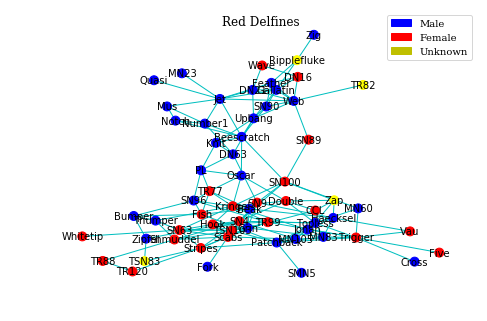

In [12]:
plt.figure()
nx.draw(dolphins,
        width=1,
        edge_color = 'c',
        node_color=["blue" if g=="m" else ("red" if g=="f" else "yellow") for g in nx.get_node_attributes(dolphins, "gender").values()], 
        node_size=80,
        font_size=10,
        with_labels=True,
       )
male = mpatches.Patch(color='b', label='Male')
female = mpatches.Patch(color='r', label='Female')
unknown = mpatches.Patch(color='y', label='Unknown')
plt.legend(handles=[male,female,unknown])
plt.suptitle('Red Delfines')
plt.show()

### Ej. 2(b): ¿Se trata de una red en la cual prevalece la homofilia en la variable género? Para responder:

#### i. Considere la distribucion nula para la fracción de enlaces que vinculan géneros diferentes, generada a partir de al menos 1000 asignaciones aleatorias de género.

#### ii. A partir de lo obtenido proponga una estimación para el valor y el error de dichas cantidad cuando no existe vínculo entre topología de la red y asignación de género. Compare su estimación con el valor medio esperado.

#### iii. Estime la significancia estadística del valor observado en el caso de la red real.

Se generan las 16 redes que surjen de colocar 'm' o 'f' a los 'na' de la red original

In [22]:
naNum = np.sum(dolphinsGender[:,1]=='NA') # Numero de nodos con genero "NA"
naGenderPos = list(itertools.product(['m','f'], repeat=naNum)) # Posibles generos de dichos nodos

edgesHeteroRatioNa = []
edgesHeteroRatioRndNa = []
pValNa = []
QNa =[]

for iterNa in range(0,len(naGenderPos)): # iteracion sobre los posibles generos de los "na"
    print('Combinacion de generos a los nodos "NA": %s'%str(naGenderPos[iterNa]))
    dolphinsNa = dolphins.copy() # Hace una copia de la red original
    na0=-1
    for n in dolphinsNa.nodes(): # Asigna el genero correspondiente a cada uno de los na
        nGender = dolphinsGender[dolphinsGender[:,0]==n,1][0]
        if nGender=='NA':
            na0+=1
            nGender = naGenderPos[iterNa][na0]
        dolphinsNa.nodes[n]["gender"] = nGender
   
    edgesHetero=0 # contador de enlaces heterofilicos
    
    for (e0,e1) in dolphinsNa.edges():
        if dolphinsNa.node[e0]['gender'] != dolphinsNa.node[e1]['gender']:
            edgesHetero+=1

    #aca calculo la fraccion de enlaces entre generos diferentes para la red de estudio
    edgesHeteroRatio=edgesHetero/edgesTot
    
    print('La fraccion de nodos heterofilicos es %e'%edgesHeteroRatio)
    
    #guardo para cada una de las redes la fraccion de enlaces entre generos distintos
    edgesHeteroRatioNa.append(edgesHeteroRatio)
    
    #Estrategia 1: permutacion 

    #luego hago 1000 asignaciones al azar del género a la red dolphinsrnd
    dolphinsRnd=dolphinsNa.copy()
    dolphinsGenderRnd = np.array(dolphinsRnd.nodes("gender"))
    edgesHeteroRatioRnd=[]
    numiter=1000
   
    for i in range(numiter):
        dolphinsGenderRnd[:,1] = random.sample(list(dolphinsGenderRnd[:,1]), nodesTot)
        for n in dolphinsRnd.nodes():
            dolphinsRnd.nodes[n]["gender"] = dolphinsGenderRnd[dolphinsGenderRnd[:,0]==n,1][0]
        edgesHeteroRnd=0
        for (e0,e1) in dolphinsRnd.edges():
            if dolphinsRnd.node[e0]['gender'] != dolphinsRnd.node[e1]['gender']:
                edgesHeteroRnd+=1
        edgesHeteroRatioRnd.append(edgesHeteroRnd/edgesTot)

    # Calculamos la probabilidad de que la proporcion de enlaces entre generos 
    # distintos sea tan o mas extrema que la observada para la red de estudio 
    # considerando que HO es verdadera (considerando como distribucion nula a la 
    # generada por permutar los sexos de los delfines, dejando inalterada la 
    # topologia de la red)

    pVal=1-sum(i >= edgesHeteroRatio for i in edgesHeteroRatioRnd)/numiter
    print('El p-valor obtenido es %e'%pVal)
    
    pValNa.append(pVal)
    edgesHeteroRatioRndNa.append(edgesHeteroRatioRnd)
    
    # Estos p-valores estarian indicando que la red tiene una proporcion de enlaces 
    # entre generos distintos mucho menor que lo esperado por azar por ende, es 
    # homofilica. Esto se mantiene asi para todas las posibles asignaciones de 
    # generos de los delfines cuyo genero no fue definido.
    
    #para cada una de las 16 redes se calcula su modularidad
    
    edgesMod = 0
    for (nodoi, nodoj) in list(dolphins.edges()): 
        # Se recorren todos los enlaces de la red.
        ki=dolphins.degree(nodoi)
        kj=dolphins.degree(nodoj)
        edgesMod += (ki*kj)/(2*edgesTot)
    Q = (edgesHetero - edgesMod)/edgesTot
    
    QNa.append(Q)
    #da un valor positivo, es decir que hay mas enlaces entre nodos del mismo tipo que lo
    #que se esperaria por azar 



Combinacion de generos a los nodos "NA": ('m', 'm', 'm', 'm')
La fraccion de nodos heterofilicos es 3.522013e-01
El p-valor obtenido es 1.000000e-03
Combinacion de generos a los nodos "NA": ('m', 'm', 'm', 'f')
La fraccion de nodos heterofilicos es 3.459119e-01
El p-valor obtenido es 1.000000e-03
Combinacion de generos a los nodos "NA": ('m', 'm', 'f', 'm')
La fraccion de nodos heterofilicos es 3.522013e-01
El p-valor obtenido es 0.000000e+00
Combinacion de generos a los nodos "NA": ('m', 'm', 'f', 'f')
La fraccion de nodos heterofilicos es 3.459119e-01
El p-valor obtenido es 0.000000e+00
Combinacion de generos a los nodos "NA": ('m', 'f', 'm', 'm')
La fraccion de nodos heterofilicos es 3.584906e-01
El p-valor obtenido es 0.000000e+00
Combinacion de generos a los nodos "NA": ('m', 'f', 'm', 'f')
La fraccion de nodos heterofilicos es 3.522013e-01
El p-valor obtenido es 0.000000e+00
Combinacion de generos a los nodos "NA": ('m', 'f', 'f', 'm')
La fraccion de nodos heterofilicos es 3.5849

Convierto listas resultantes en numpy arrays:

In [23]:
edgesHeteroRatioNa = np.array(edgesHeteroRatioNa)
edgesHeteroRatioRndNa = np.array(edgesHeteroRatioRndNa)
pValNa = np.array(pValNa)
QNa = np.array(QNa)

[('Ripplefluke', 'Feather'), ('Ripplefluke', 'Gallatin'), ('Ripplefluke', 'Zig')]


Graficamos:

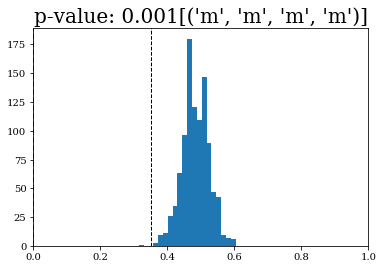

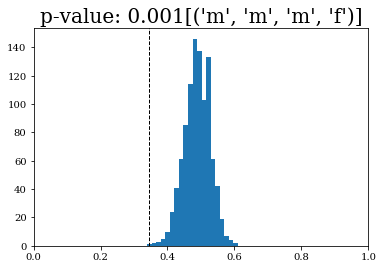

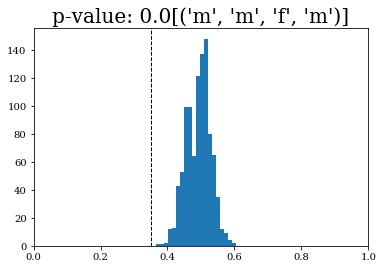

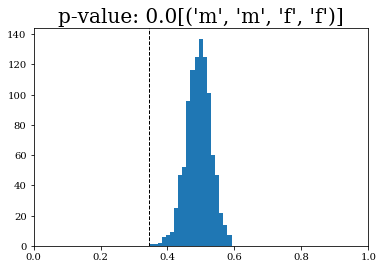

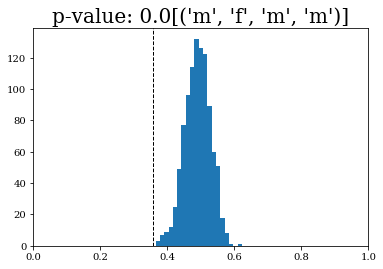

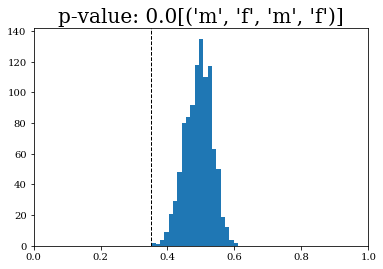

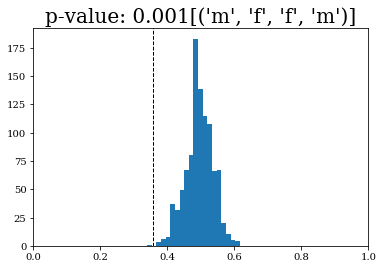

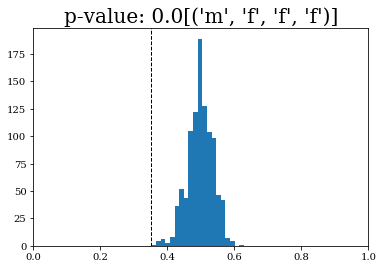

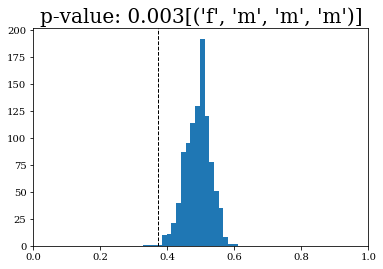

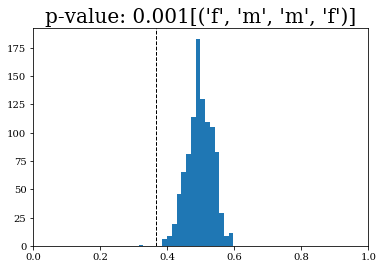

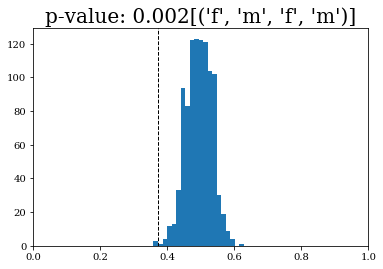

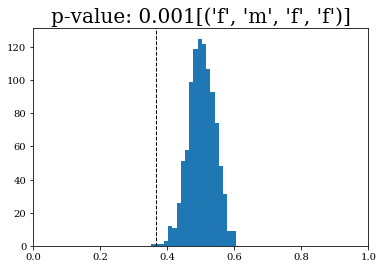

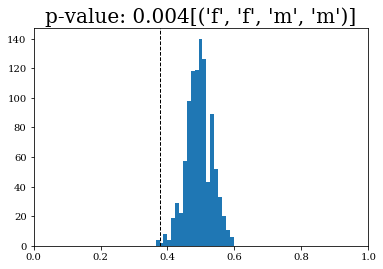

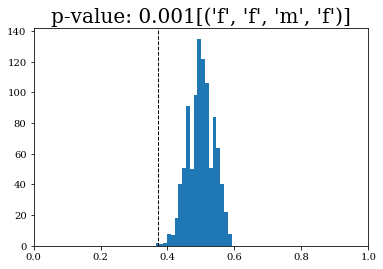

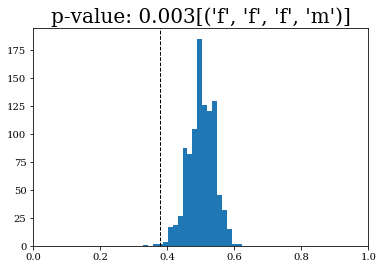

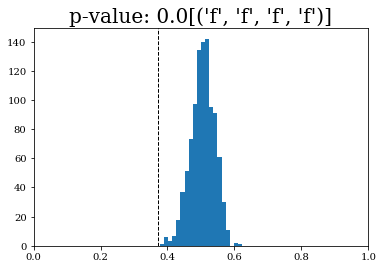

In [50]:
for iterNa in range(0,len(naGenderPos)):
    plt.hist(edgesHeteroRatioRndNa[iterNa,:], bins=20)
    plt.axvline(edgesHeteroRatioNa[iterNa], color='k', linestyle='dashed', linewidth=1)
    plt.title('p-value: ' + str(pValNa[iterNa]) + '[' + str(naGenderPos[iterNa]) + ']',fontsize=20)
    plt.xlim(0,1)
    if iterNa==0:
        plt.axvline(color='k', linestyle='dashed', label='Fraccion original')
    axs[iterNa].invert_xaxis()
    axs[iterNa].yaxis.set_label_position("right")

    fig.text(0.5, 0.025, 'Fraccion de enlaces heterofilicos', ha='center', va='center', fontsize=25)
    fig.text(0.20, 0.5, 'Frecuencia', ha='center', va='center', rotation='vertical', fontsize=25)
    fig.suptitle('Distribuciones nulas de redes con asignacion de generos al azar', ha='center', va='center', fontsize=25)
    fig.legend(bbox_to_anchor=(0.85, 0.5), shadow=True, fontsize='xx-large')

    plt.show()




Respuesta: Para todas las posibles asignaciones de generos a los nodos "NA", prevalece la homofilia en la red. 

### Ej. 2(c): Identifique alguna metodología basada en observables topológicos para eliminar nodos secuencialmente de la red de manera de dividirla en dos componentes de tamaños comparables en el menor número de pasos. Explique y muestre los resultados obtenidos. Intente cuantificar su estrategia comparándola con lo que se obtendría al eliminar nodos de manera aleatoria.

La estrategia sera ir eliminando en cada paso aquel nodo que resulte ser el que constituya parte de la mayor cantidad de "caminos mas cortos posibles" entre dos nodos cualesquiera. Dicha iteracion concluira una vez que la red se halle disconexa. Es esperable que dicha estrategia corte rapidamente la red, aunque debe notarse que esto no garantiza generalmente que las componentes disconexas resulten ser dos de tamaños comparables, por ejemplo no ocurriria asi si el grafo fuera una estrella.

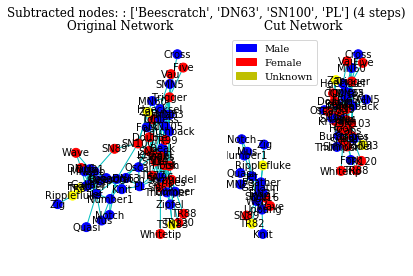

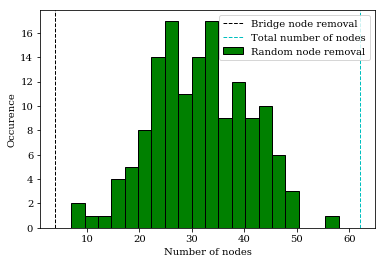

In [51]:
nx.transitivity(dolphins)
dolphinsCut = dolphins.copy()

node2extract=[]
while nx.is_connected(dolphinsCut):
    shortPaths = nx.shortest_path(dolphinsCut)
    numShortPaths = dict((n,0) for n in dolphinsCut.nodes())
    for n1 in dolphinsCut.nodes():
        for n2 in dolphinsCut.nodes():
            shortPathList = shortPaths[n1][n2][1:-1]
            for n in dolphinsCut.nodes():
                if n in shortPathList:
                    numShortPaths[n] = numShortPaths[n]+1
    node2extract.append(max(numShortPaths, key=numShortPaths.get))
    dolphinsCut.remove_node(node2extract[-1])

In [ ]:
# Ilustramos el resultado con dicho metodo
dolphinNet = [dolphins,dolphinsCut]
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for sp in range(0,2):
    plt.sca(axs[sp])
    nx.draw(dolphinNet[sp],
            width=1,
            edge_color = 'c',
            node_color=["blue" if g=="m" else ("red" if g=="f" else "yellow") for g in nx.get_node_attributes(dolphinNet[sp], "gender").values()], 
            node_size=80,
            font_size=10,
            with_labels=True,
           )
    male = mpatches.Patch(color='b', label='Male')
    female = mpatches.Patch(color='r', label='Female')
    unknown = mpatches.Patch(color='y', label='Unknown')
    plt.suptitle('Subtracted nodes: ' ': ' + str(node2extract) + ' (' + str(len(node2extract)) + ' steps)')
    if sp==0:
        plt.title('Original Network')
    elif sp==1:
        plt.title('Cut Network')
        plt.legend(handles=[male,female,unknown])
plt.show()



Ahora, compararemos con el numero de pasos requeridos al extraer nodos aleatorios. Notese que, para conservar la condicion de separar la red en grafos de tamano comparable, dicha aleatoriedad sera restringida por la condicion de que ninguno de los subgrafos resultantes contenga menos de 10 nodos. Es decir, se rechazara la eliminacion de nodos perifericos que separen a la red en un bloque muy grande y otro muy pequeno.

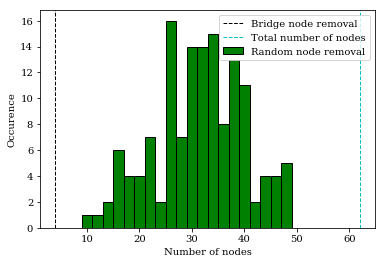

In [52]:
R = 150
numNodes = []
for r in range(0,R):
    dolphinsCut = dolphins.copy()
    node2extract2=[]
    thresh=0
    try:
        while nx.is_connected(dolphinsCut):
            candidate = random.choice(list(dolphinsCut.nodes()))
            dolphinsCutCand = dolphinsCut.copy()
            dolphinsCutCand.remove_node(candidate)
            subGr = list(nx.connected_component_subgraphs(dolphinsCutCand))
            if len(subGr)>1 and len(min(subGr,key=len))<5 and thresh<10:
                thresh+=1
                continue
            else:
                thresh=0
                node2extract2.append(candidate)
                dolphinsCut = dolphinsCutCand.copy()
        numNodes.append(len(node2extract2))
    except:
        continue
# Graficamos el histograma resultante y comparamos con el metodo anterior
plt.figure()
plt.hist(numNodes, bins=20, color='g', edgecolor='k', label='Random node removal')
plt.axvline(4, color='k', linestyle='dashed', linewidth=1, label='Bridge node removal')
plt.axvline(len(dolphins.nodes()), color='c', linestyle='dashed', linewidth=1, label='Total number of nodes')
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('Occurence')
plt.show()


Se observa que el numero de nodos a extraer es siempre superior en el caso aleatorio.

### Ej. 3: Considere la red as-22july06.gml creada por Mark Newman que contiene la estructura de los sistemas autónomos de internet relevada a mediados de 2006.

In [7]:
# Cargamos los datos:

Newman = nx.read_gml(path + 'as-22july06.gml')

### Ej. 3(a): Encuentre gráficamente la distribución de grado P_k como función de k explorando diferentes alternativas: un bineado lineal o logarítmico, utilizando escalas logarítmicas o lineales en uno o ambos ejes. Discuta que alternativa permite apreciar mejor el carácter libre de escala de dicha distribución.

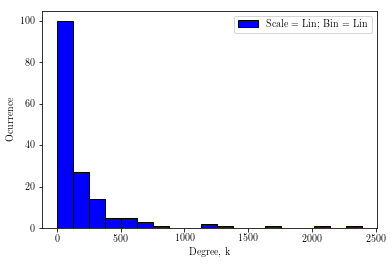

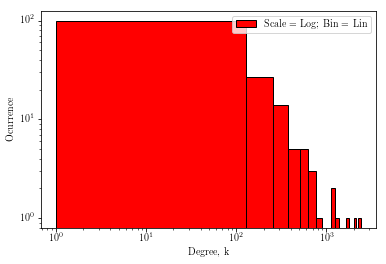

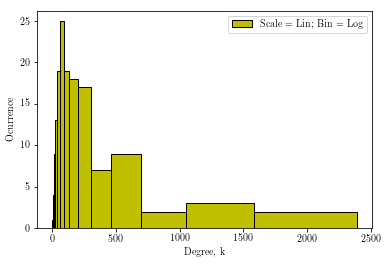

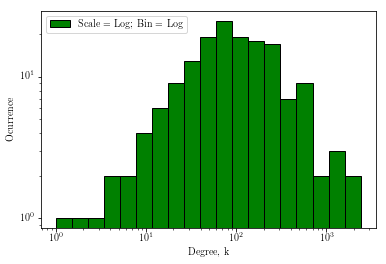

In [10]:


degree_sequence = sorted([d for n, d in Newman.degree()], reverse=True)  # Se arma la sucesión de los grados (ordenada).
degreeCount = collections.Counter(degree_sequence) # Se cuenta cuántos nodos hay con cada grado.
deg, cnt = zip(*degreeCount.items()) # Se almacenan los grados y la cantidad de nodos con ese grado.

scaleBinning = ['linear','log']

binsLin = np.linspace(min(deg),max(deg),20)
binsLog = np.logspace(np.log10(min(deg)),np.log10(max(deg)),20)

sp=0
%matplotlib inline
fig = plt.figure()
plt.hist(deg, bins=binsLin, color='b',edgecolor='k',label='Scale = Lin; Bin = Lin')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel('Degree, k')
plt.ylabel('Ocurrence')
plt.legend()
plt.show()

fig = plt.figure()
plt.hist(deg, bins=binsLin, color='r',edgecolor='k',label='Scale = Log; Bin = Lin')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree, k')
plt.ylabel('Ocurrence')
plt.legend()
plt.show()

fig = plt.figure()
plt.hist(deg, bins=binsLog, color='y',edgecolor='k',label='Scale = Lin; Bin = Log')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel('Degree, k')
plt.ylabel('Ocurrence')
plt.legend()
plt.show()

fig = plt.figure()
plt.hist(deg, bins=binsLog, color='g',edgecolor='k',label='Scale = Log; Bin = Log')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree, k')
plt.ylabel('Ocurrence')
plt.legend()
plt.show()


La alternativa que mejor permite apreciar el carácter libre de escala es: escala log-log, bineado lineal (graficado en rojo).

In [20]:
igraph.power_law_fit(deg, method='discrete')

FittedPowerLaw(continuous=False, alpha=2.3399145324673, xmin=194.0, L=-309.07369713449475, D=0.08356612825010135, p=0.9049922634403245)

### Ej. 4) Asortatividad

### a) Considere la red de colaboraciones científicas (netscience.gml) y la red de internet (as-july06.gml). Analice si nodos de alto grado tienden a conectarse con nodos de alto grado o por el contrario suelen conectarse a nodos de bajo grado? (i.e la red es asortativa o disortativa respecto al grado?).

#### i. Determine, para nodos de grado  k, cuánto vale en media el grado de sus vecinos.

In [107]:
redesStr = ['netscience','as-22july06']
redes = {}
avnd = {}
degree0 = {}
nodes = {}
degreeAvnd = {}
ds = {}
d = {}
indx = []

for s in range(len(redesStr)): 
    redes[s] = nx.read_gml(path + redesStr[s] + '.gml')
    nodes[s] = redes[s].nodes()
#nombres de los nodos
    avnd[s] = nx.average_neighbor_degree(redes[s]) 
#diccionario con el grado promedio de los vecinos de cada nodo.
    degree0[s] = redes[s].degree() 
#grado de cada nodo.

    ds[s] = [dict(degree0[s]), avnd[s]]
    
    for k in avnd[s].keys():
       d[s][k] = list(d[s][k] for d[s] in ds[s])

    degreeAvnd[s] = d[s].values()
    degreeAvnd[s] = np.array(list(degreeAvnd[s]))
    
#primero voy a eliminar los 0 de degreeAvnd para poder realizar el ajuste lineal de logx-logy en el punto ii.

    for k in range(len(degreeAvnd[s][:,0])):
        if degreeAvnd[s][k,0] == 0:
            indx.append(k)
            
#unicamente la primer red tiene nodos desconectados, borro esos registros de degreeAvnd

degreeAvnd[0] = np.delete(degreeAvnd[0], indx, axis=0)



#### ii. Analizar la tendencia observada en un gráfico que consigne dicho valor k nn (k) como función del grado. 
#### iii.Asumiendo que k_nn (k) = ak^μ , estime el exponente de correlación a partir de realizar una regresión de log k_nn ~ log k. Asegúrese de graficar el fiteo en el gráfico anterior. 

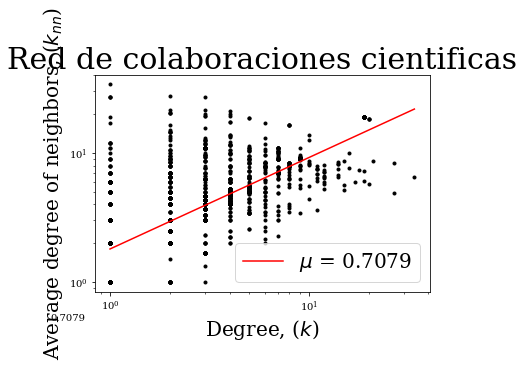

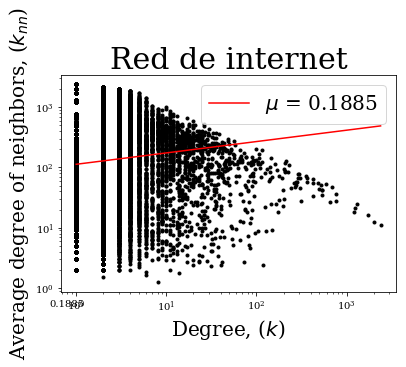

In [108]:
model = {}
redesTitle = ['colaboraciones cientificas', 'internet']
mu = []
b = []

for s in range(len(degreeAvnd)):

    # x from 0 to 30
    
    x = np.transpose(degreeAvnd[s][:,0])
    y = np.transpose(degreeAvnd[s][:,1])
    
    x = x.reshape((-1,1))  # conversion between (N,) dimension arrays and (N,1) 
    y = y.reshape((-1,1))
    
    logx = np.log10(x)
    logy = np.log10(y)
    
    logx = logx.reshape((-1,1))
    logy = logy.reshape((-1,1))
    
    model[s] = LinearRegression()
    model[s].fit(logx, logy)
    
    logx_new = np.linspace(min(logx), max(logx), 100)
    logy_new = model[s].predict(logx_new[:, np.newaxis])
    
    mu.append(round(float(model[s].coef_),4))
    b.append(round(float(model[s].intercept_),4))
    
    plt.figure()
    plt.plot(x, y,'.k')
    plt.plot(10**logx_new, 10**logy_new,'r', label = r'$\mu$'+ ' = ' + str(mu[s]))
    plt.text(0.5, 0.5, str(mu[s]))
    plt.xlabel(r'Degree, ($k$)', fontsize=20)
    plt.ylabel(r'Average degree of neighbors, ($k_{nn}$)', fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Red de ' + redesTitle[s] ,fontsize=30)
    plt.legend(fontsize=20)
    plt.show()

#### iv. Considere la red de colaboraciones y la de internet nuevamente Encuentre cuantitativamente la asortatividad de la red utilizando ahora el estimador propuesto por Newman (ver PDF). Para ello tenga encuenta lo desarrollado en las eqs [8.26 – 8.29] del libro de Newman.Como se corresponde este coeficiente con el estimado en el punto anterior? A qué se debe?

In [109]:
rNewman_redes = []
rNX_redes = []
redesTitle = ['colaboraciones cientificas', 'internet']

for s in range(len(redes)): 
    # Se arma un vector 'netDeg4' con los grados de cada nodo:
    netDeg4 = np.array(redes[s].degree())
    # Lista con los grados de cada nodo
    netDeg4Grados = netDeg4[:,1].astype(int)   
    
    # Usando el método del libro (Newman, ecuaciones 8.26-8.29):
    
    S1=sum(netDeg4Grados)
    S2=sum(netDeg4Grados**2)
    S3=sum(netDeg4Grados**3)
    
    suma=0
    for (nodoi, nodoj) in list(redes[s].edges()): 
    # Se recorren todos los enlaces de la red.
        ki=redes[s].degree(nodoi)
        kj=redes[s].degree(nodoj)
        suma += ki*kj
    
    Se=2*suma
    
    rNewman=(S1*Se-S2**2)/(S1*S3-S2**2)
    rNewman_redes.append(rNewman)
    
    
    rNX=nx.degree_assortativity_coefficient(redes[s])
    rNX_redes.append(rNX)
    
    print('Red de ' + redesTitle[s])
    print('Coeficiente de correlación (Newman):\nr= ',rNewman)
    print('Coeficiente de correlación (función de Networkx):\nr= ',rNX)

Red de colaboraciones cientificas
Coeficiente de correlación (Newman):
r=  0.461622466753
Coeficiente de correlación (función de Networkx):
r=  0.461622466753
Red de internet
Coeficiente de correlación (Newman):
r=  -0.198384875121
Coeficiente de correlación (función de Networkx):
r=  -0.198384875121


Falta comparar con el punto anterior.
 

### b) Corra el script de cálculo (puntos i-iii) para las redes Y2H y AP-MS. Puede explicar lo que observa en cuanto a la asortatividad reportada?

#### i.Determine, para nodos de grado k, cuánto vale en media el grado de sus vecinos.

In [110]:
redesStr = ['Y2H','AP-MS']
redes = {}
avnd = {}
degree0 = {}
nodes = {}
degreeAvnd = {}
ds = {}
d = {}
indx = []

for s in range(len(redesStr)):
    redes[s] = nx.Graph(ldata(path + 'yeast_' + redesStr[s] + '.txt'))
    nodes[s] = redes[s].nodes()
    avnd[s] = nx.average_neighbor_degree(redes[s]) 
    degree0[s] = redes[s].degree() 
    
    ds[s] = [dict(degree0[s]), avnd[s]]
    
    for k in avnd[s].keys():
       d[s][k] = list(d[s][k] for d[s] in ds[s])

    degreeAvnd[s] = d[s].values()
    degreeAvnd[s] = np.array(list(degreeAvnd[s]))

#### ii. Analizar la tendencia observada en un gráfico que consigne dicho valor k nn (k) como función del grado.
#### iii.Asumiendo que k_nn (k) = ak^μ , estime el exponente de correlación a partir de realizar una regresión de log k_nn ~ log k. Asegurese de graficar el fiteo en el grafico anterior. 

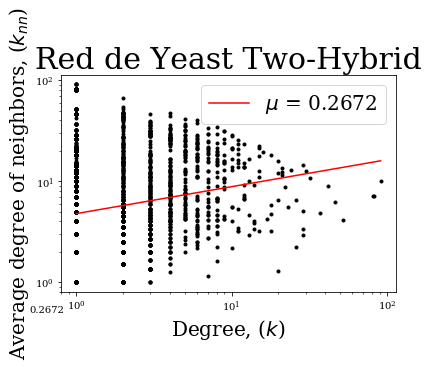

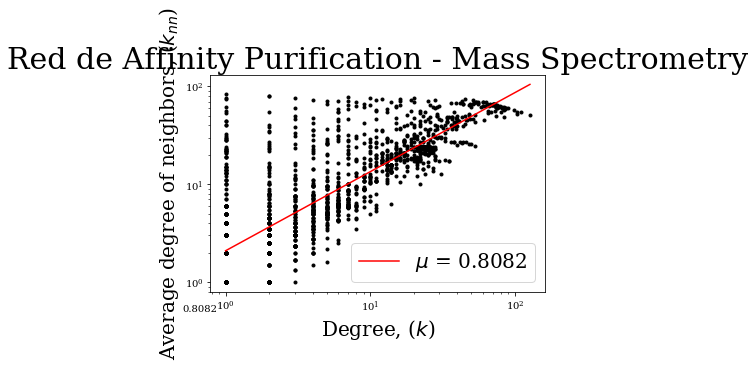

In [111]:
model = {}
redesTitle = ['Yeast Two-Hybrid', 'Affinity Purification - Mass Spectrometry']
mu = []
b = []

for s in range(len(degreeAvnd)):

    # x from 0 to 30
    
    x = np.transpose(degreeAvnd[s][:,0])
    y = np.transpose(degreeAvnd[s][:,1])
    
    x = x.reshape((-1,1))  # conversion between (N,) dimension arrays and (N,1) 
    y = y.reshape((-1,1))
    
    logx = np.log10(x)
    logy = np.log10(y)
    
    logx = logx.reshape((-1,1))
    logy = logy.reshape((-1,1))
    
    model[s] = LinearRegression()
    model[s].fit(logx, logy)
    
    logx_new = np.linspace(min(logx), max(logx), 100)
    logy_new = model[s].predict(logx_new[:, np.newaxis])
    
    mu.append(round(float(model[s].coef_),4))
    b.append(round(float(model[s].intercept_),4))
    
    plt.figure()
    plt.plot(x, y,'.k')
    plt.plot(10**logx_new, 10**logy_new,'r', label = r'$\mu$'+ ' = ' + str(mu[s]))
    plt.text(0.5, 0.5, str(mu[s]))
    plt.xlabel(r'Degree, ($k$)', fontsize=20)
    plt.ylabel(r'Average degree of neighbors, ($k_{nn}$)', fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Red de ' + redesTitle[s] ,fontsize=30)
    plt.legend(fontsize=20)
    plt.show()